# 0.0 imports

In [58]:
import pandas as pd
import os
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle


from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from IPython.display       import Image
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error


# 0.1 Helper functions

In [2]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['font.size'] = 15


def cross_validation( x_training, kfold, model_name, model):

    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed(range(1,kfold+1)):
        print('\nKFold Number:{}'.format(k))

        # start and end of validation time
        validation_start_date = x_training['date'].max() - datetime.timedelta( days= k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days= (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date) & 
                                (x_training['date']<=validation_end_date)]
        # training and validation dataset
        ytraining = training['sales']
        yvalidation = validation['sales']
        xtraining = training.drop(['date','sales'], axis=1)
        xvalidation = validation.drop(['date','sales'], axis=1)

        # Model
        m = model().fit(xtraining, ytraining)


        # Prediction
        yhat = m.predict(xvalidation)


        # Performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))
        print(lr_result)

        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


        return pd.DataFrame({'Model Name': model_name,
                             'MAE CV': np.round( np.mean(mae_list),2).astype( str ) + '+/-' + np.round( np.std(mae_list),2).astype( str ),
                             'MAPE CV': np.round( np.mean(mape_list),2).astype( str ) + '+/-' + np.round( np.std(mape_list),2).astype( str ),
                             'RMSE CV': np.round( np.mean(rmse_list),2).astype( str ) + '+/-' + np.round( np.std(rmse_list),2).astype
         ( str )}, index=[0])


# 0.2 Loading data

In [3]:
# os.getcwd()
# os.chdir('C:/Users/Pedro Enrique/anaconda3/envs/DataScienceEmProducao')
df_sales_raw = pd.read_csv('D:/curso_data_science/train.csv', low_memory=False)
df_store_raw = pd.read_csv('D:/curso_data_science/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

#df_raw.sample()

# 1.0 DESCRIÇÃO DOS DADOS

## 1.1 Rename Columns

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [7]:
snakecase = lambda x:inflection.underscore(x)
cols_new = list( map(snakecase, cols_old))

#rename
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NAs

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance              

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan ( x ) else x )



#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )


#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )


#promo2_since_week               
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )


#promo2_since_year               
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

#promo_interval                  
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6: 'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)



In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [13]:
df1.sample(5).T

,688513,44945,720053,828842,800064
store,229,346,549,68,280
day_of_week,2,7,2,2,7
date,2013-10-22 00:00:00,2015-06-21 00:00:00,2013-09-24 00:00:00,2013-06-18 00:00:00,2013-07-14 00:00:00
sales,8039,0,4792,6371,0
customers,717,0,531,981,0
open,1,0,1,1,0
promo,1,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,a,a,d


## 1.6 Data Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )


In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive statistical

In [16]:
# Variaveis numéricas e Categóricas

#Central tendency - mean, median

# Dispersion - desvio padrão, min, max, range, skew and kurtosis

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7.1 Numerical Attributes

In [18]:
num_attributes.sample(3)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
807985,396,7,0,0,0,0,0,23130.0,7,2013,0,27,2013,0
82201,807,2,9426,974,1,1,0,3870.0,4,2008,0,21,2015,0
366792,533,4,7548,765,1,0,1,5950.0,8,2014,0,33,2014,0


In [19]:
#Central tendency - mean, median
ct1 =  pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 =  pd.DataFrame( num_attributes.apply(np.median)).T


# Dispersion - desvio padrão, min, max, range, skew and kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenar dados

metricas = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metricas.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'std', 'Skew', 'Kurtosis']




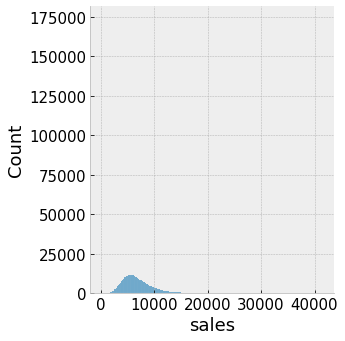

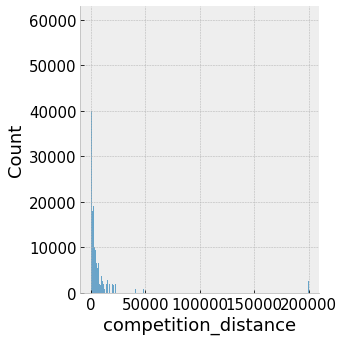

In [20]:
sns.displot (df1['sales']);
sns.displot (df1['competition_distance']);

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

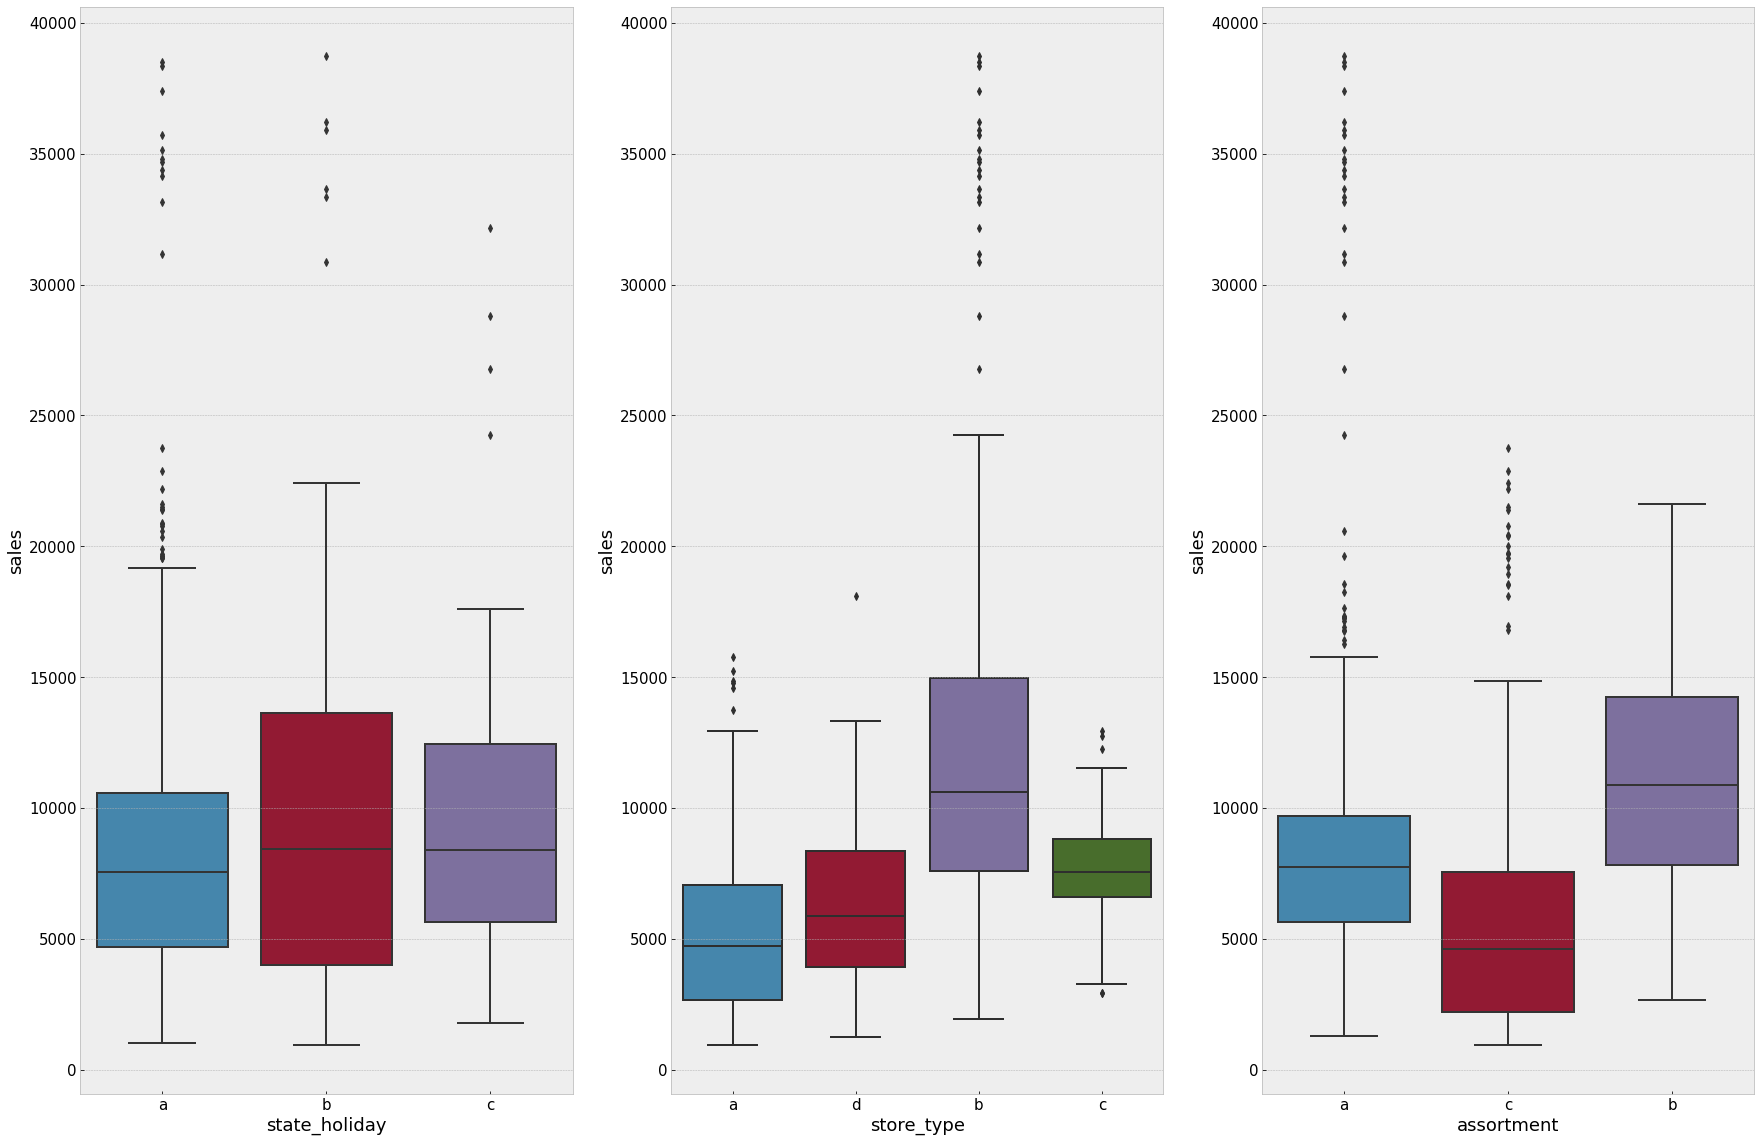

In [22]:
aux1 = df1[(df1['state_holiday']!= '0' ) & (df1['sales'] > 0)]

plt.subplot (1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1 )

plt.subplot (1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1 )

plt.subplot (1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1 )



# 2.0 FEATURE ENGINEERING

In [23]:
# Fenômeno - É aquilo que estamos modelando

#Agentes - são aqueles que atuam sobre o fenômeno 

#Atributos do agente - são as caracteristicas que definem este agente


In [24]:
df2 = df1.copy()

## 2.1 Mapa mental de hipotesis

### 2.1 Criação de Hipotesis

### 2.1.1 Hipoteses de Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2** Lojas com maior estoque deveriam vender mais.

**3** Lojas com maior porte deveriam vender mais.

**4** Lojas com menor porte deveriam vender menos.

**5** Lojas com maior sortimento deveriam vender mais.

### 2.1.2 Hipoteses do Produto

**1** Lojas que investem mais em marketing deveriam vender mais.

**2** Lojas que expoem mais os produtos na vitrine deveriam vender mais.

**3** Lojas que investem mais em marketing deveriam vender mais.

**4** Lojas com preços menores por mais tempo deveriam vender mais.

### 2.1.3 Hiposteses temporais

**1** Lojas que estão em mais feriados, deveriam vender menos.

**2** Lojas abrem nos 6 primeiros meses deveriam vender mais.

**3** Lojas que que abrem nos finais de semana deveriam vender mais.

## 2.2 Lista final de Hipótesis

**1** Lojas com maior sortimento deveriam vender mais.

**2** Lojas com competidores próximos deveriam vender menos.

**3** Lojas com competidores a mais tempo deveriam vender mais.

**4** Lojas com promoções ativas por maior tempo deveriam vender mais.

**5** Lojas com mais dias em promoção deveriam vender mais.

**6** Lojas com mais promoções consecutivas deveriam vender mais.

**7** Lojas abertas durante o feriado de Natal, deveriam vender menos.

**8** Lojas deveriam vender mais no segundo semestre do ano.

**9** Lojas que que abrem nos finais de semana deveriam vender mais.

**10** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11** Lojas deveriam vender menos durante os feriados escolares.

**12** Lojas deveriam vender mais ao longo dos anos.







## 2.3 Feature Engineering

In [25]:
df2.sample().T

,482501
store,492
day_of_week,5
date,2014-04-25 00:00:00
sales,6655
customers,1048
open,1
promo,0
state_holiday,0
school_holiday,1
store_type,a


In [26]:
#year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply (lambda x: x.days ).astype(np.int64)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str ) 
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days ).astype( int )

# assortment

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x == 'c' else 'regular_day')


<ipython-input-26-5639c13a8be4>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [28]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [29]:
#cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
#df3 = df3.drop( cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [31]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

In [32]:
# sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

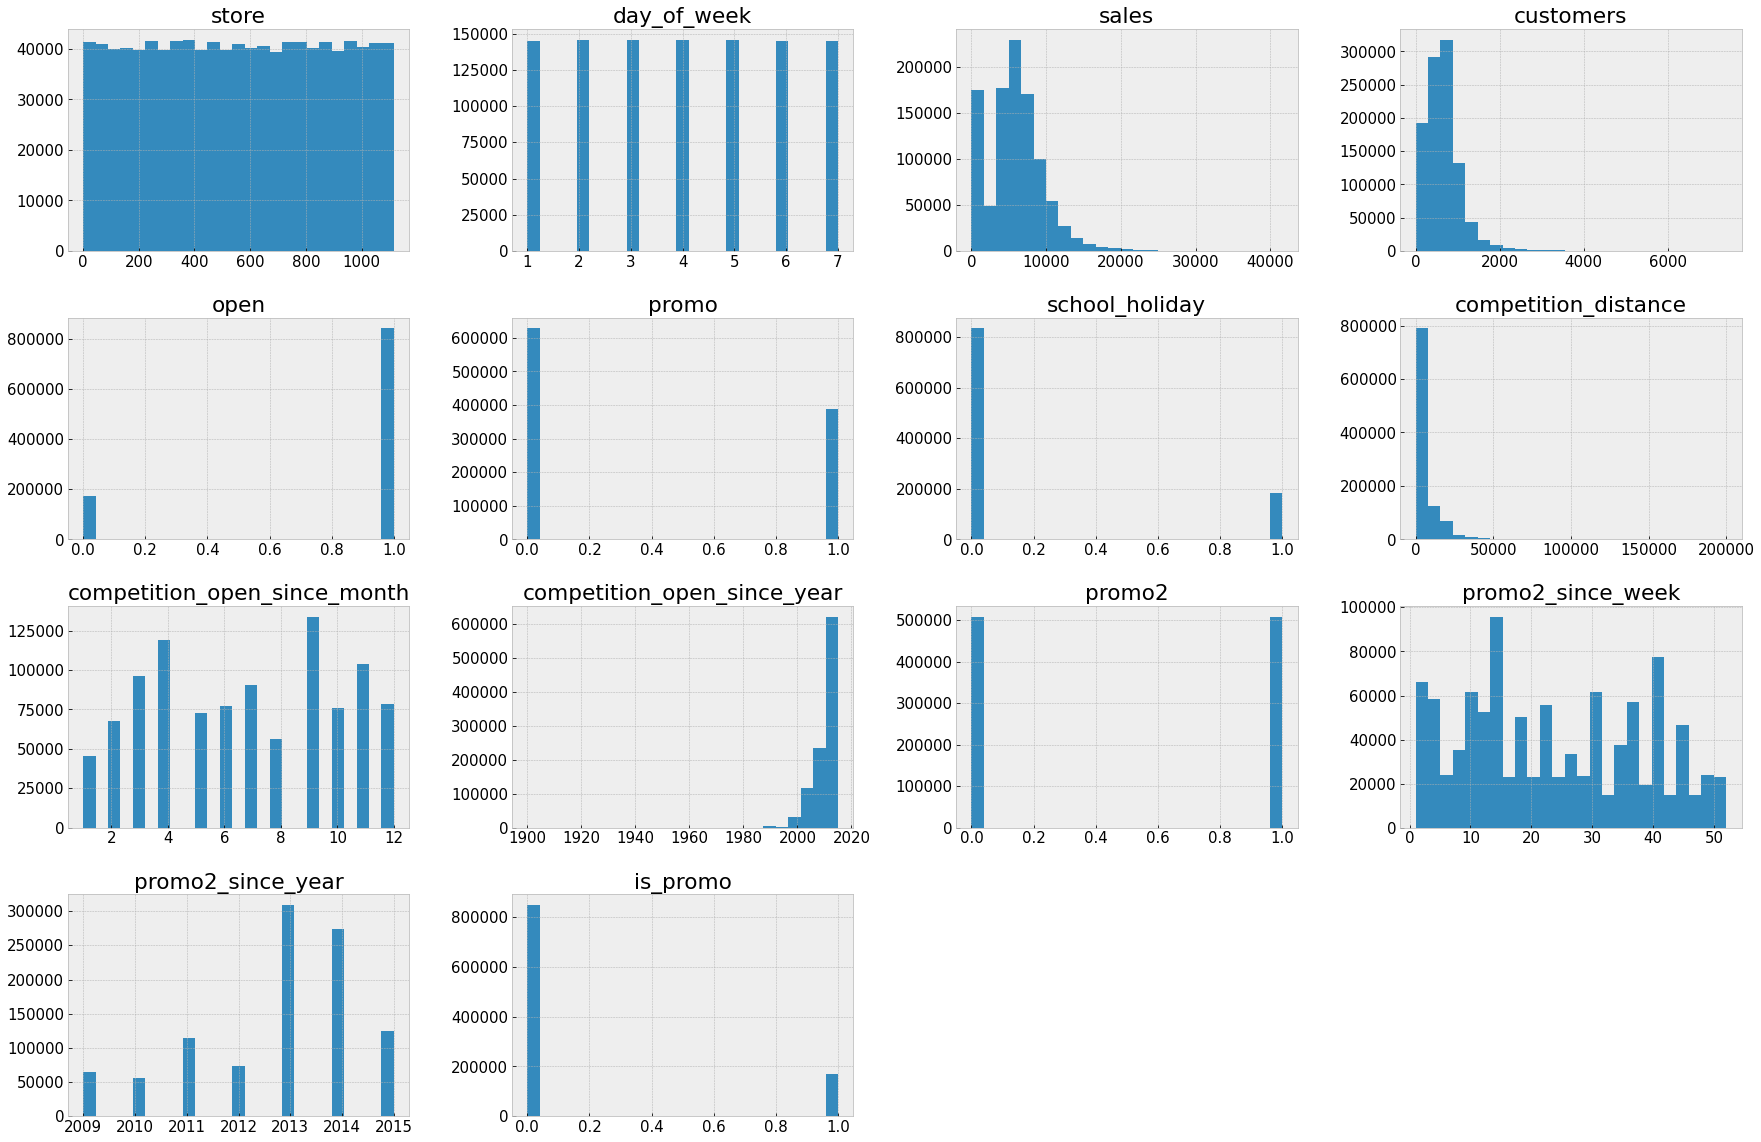

In [33]:
num_attributes.hist( bins=25);

### 4.1.3 Categorical Variable

In [34]:
cat_attributes.head(10)

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
5,0,a,a,0,Jul
6,0,a,c,0,Jul
7,0,a,a,0,Jul
8,0,a,c,0,Jul
9,0,a,a,0,Jul


In [35]:
df4[df4['state_holiday'] == 'christmas']

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
241126,85,5,2014-12-26,9741,1161,1,0,christmas,1,b,...,0,2014,12,26,52,2014-51,2011-10-01,39,2014-12-22,0
241267,259,5,2014-12-26,17597,2544,1,0,christmas,1,b,...,0,2014,12,26,52,2014-51,2014-12-01,0,2014-12-22,0
241270,262,5,2014-12-26,32169,4468,1,0,christmas,1,b,...,0,2014,12,26,52,2014-51,2013-05-01,20,2014-12-22,0
241281,274,5,2014-12-26,7818,1412,1,0,christmas,1,b,...,0,2014,12,26,52,2014-51,2014-12-01,0,2013-03-04,94
241298,299,5,2014-12-26,1800,190,1,0,christmas,1,d,...,0,2014,12,26,52,2014-51,2012-09-01,28,2014-12-22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617657,733,3,2013-12-25,12223,2335,1,0,christmas,1,b,...,0,2013,12,25,52,2013-51,1999-10-01,173,2013-12-23,0
617693,769,3,2013-12-25,10033,2055,1,0,christmas,1,b,...,0,2013,12,25,52,2013-51,2013-12-01,0,2012-11-19,57
617872,948,3,2013-12-25,7138,1320,1,0,christmas,1,b,...,0,2013,12,25,52,2013-51,2013-12-01,0,2013-12-23,0
618005,1081,3,2013-12-25,1929,335,1,0,christmas,1,b,...,0,2013,12,25,52,2013-51,2006-03-01,95,2013-12-23,0


D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

<AxesSubplot:xlabel='sales', ylabel='Density'>

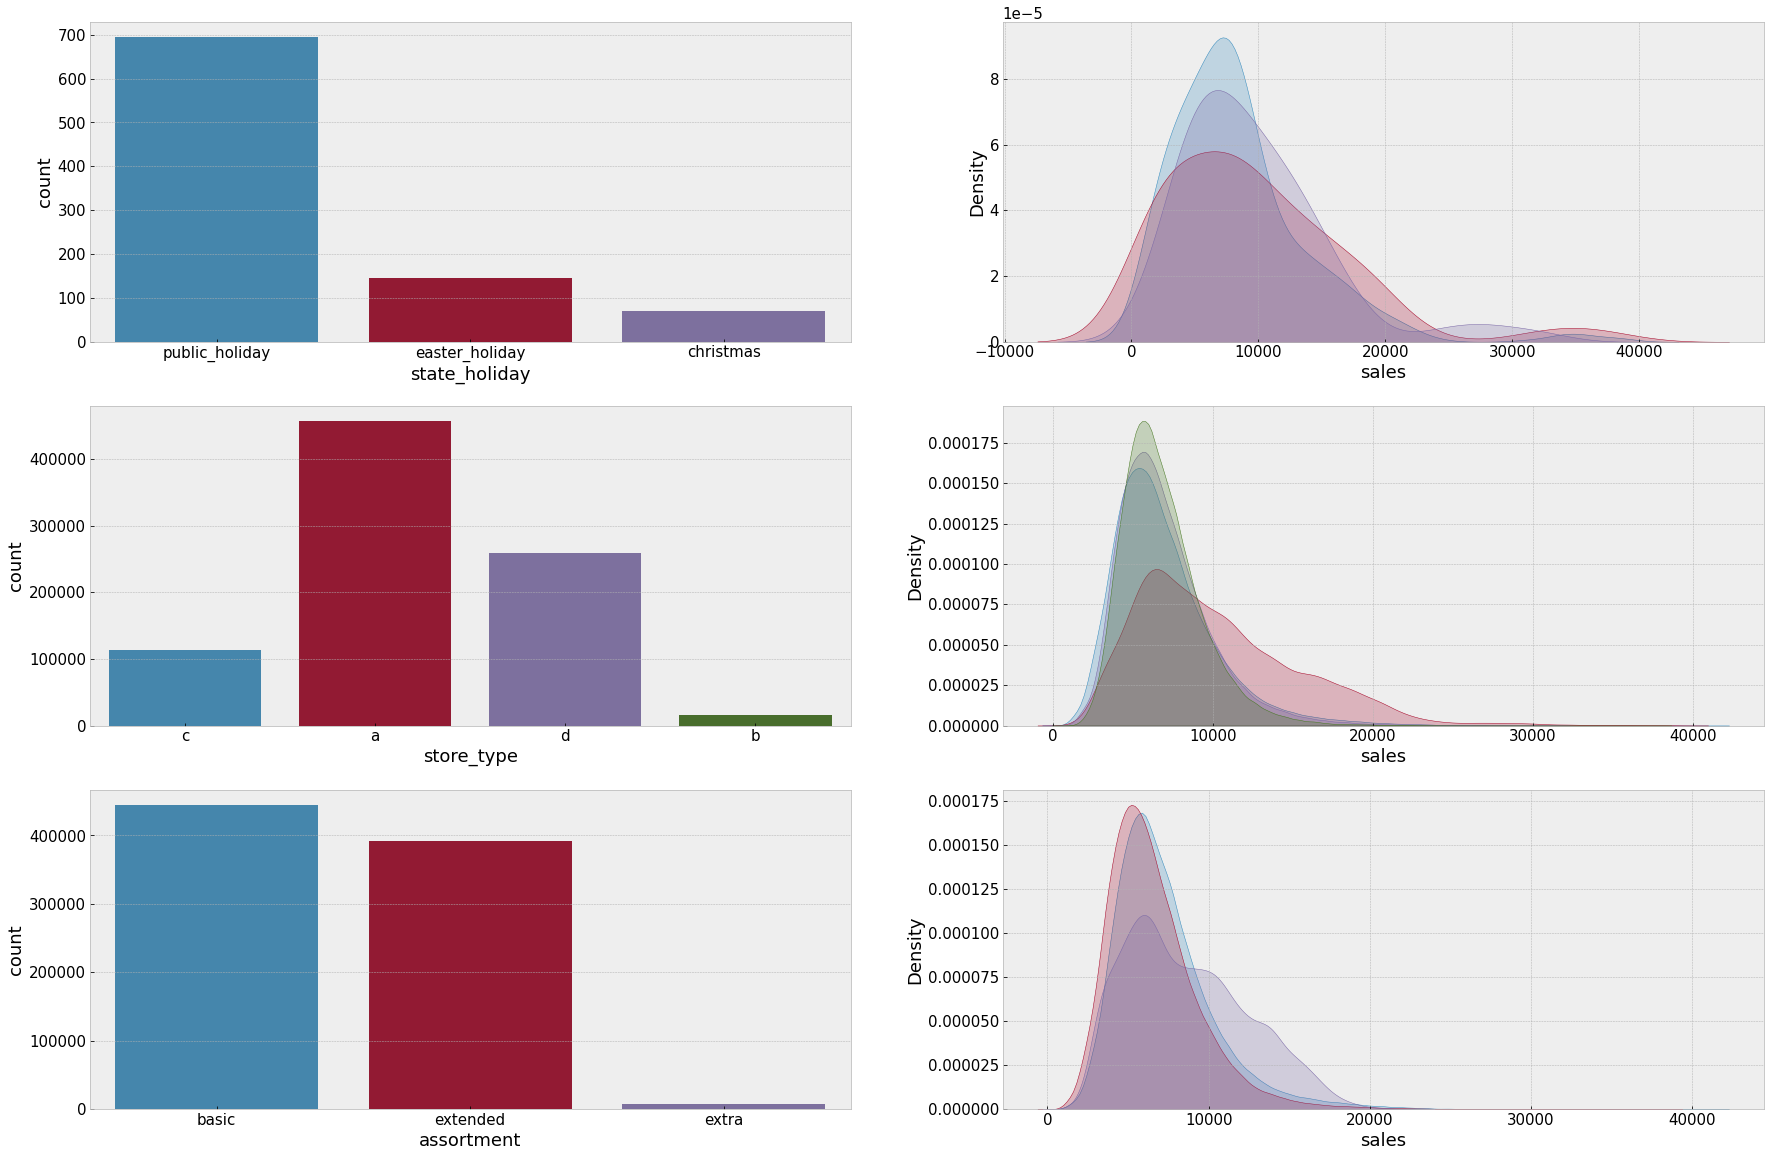

In [36]:
# state_holiday
plt.subplot(3,2,1)

a = df4[df4['state_holiday'] != 'regular_day'];
sns.countplot( a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)

#store_type
plt.subplot(3,2,3)

a = df4[df4['state_holiday'] != 'regular_day'];
sns.countplot( df4['store_type']);

plt.subplot(3,2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
#assortment

plt.subplot (3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)





## 4.2 Análise Bivariada

In [37]:
#  Lojas com maior variedade de sortimentos deveriam vender mais
# FALSO, LOJAS COM MAIOR ASSORTMENT VENDEM MENOS


# aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
# sns.barplot( x='assortment', y='sales', data=aux1 );

# aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
# aux2.pivot(index= 'year_week' , columns= 'assortment' , values='sales' ).plot()


# aux3 = aux2[aux2['assortment'] == 'extra']
# aux3.pivot(index= 'year_week' , columns= 'assortment' , values='sales' ).plot()




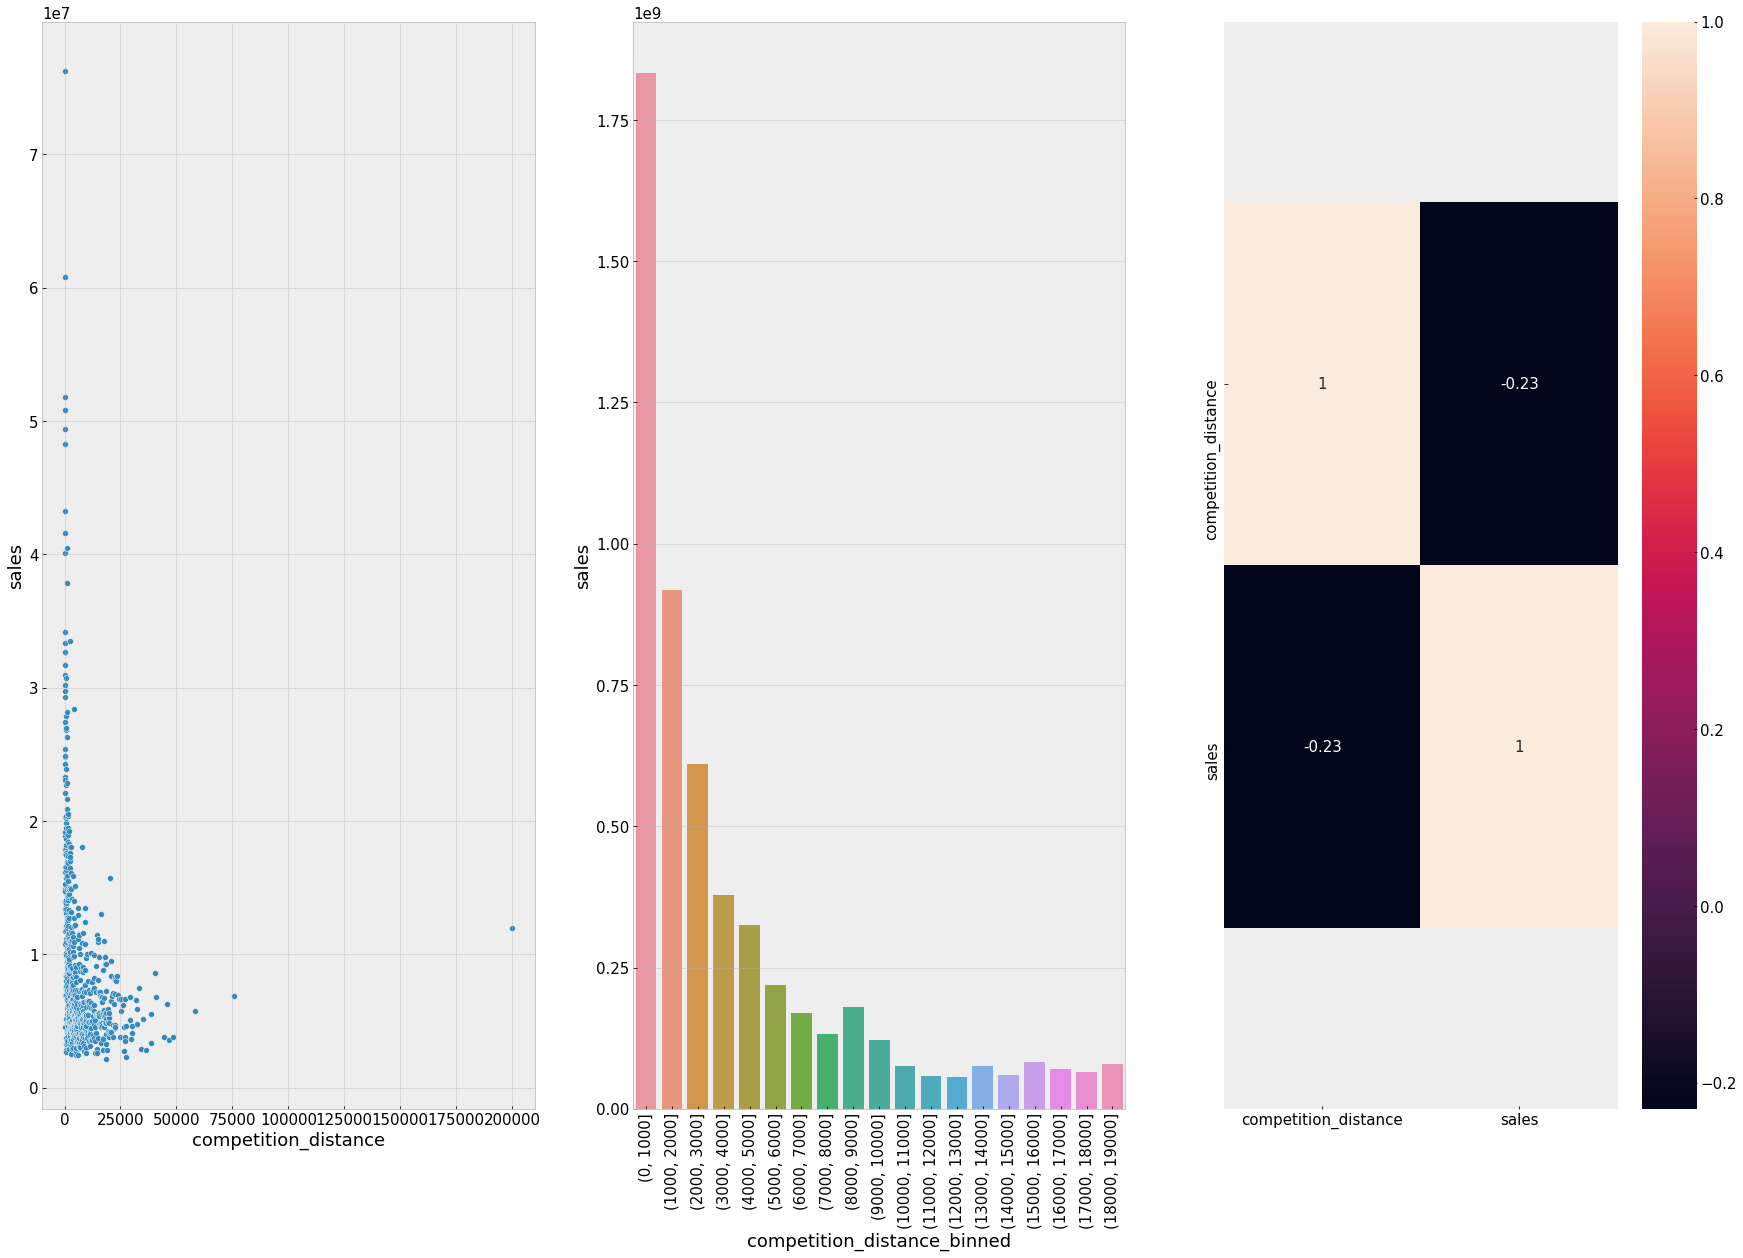

In [38]:
# H2 Lojas com competidores mais prox deveriam vender menos
# FALSO, LOJAS COM COMPETIDORES MAIS PROXIMOS VENDEM MAIS

plt.subplot(1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x= 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins= bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data= aux2);
plt.xticks( rotation = 90)

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr(method = 'pearson'), annot = True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);







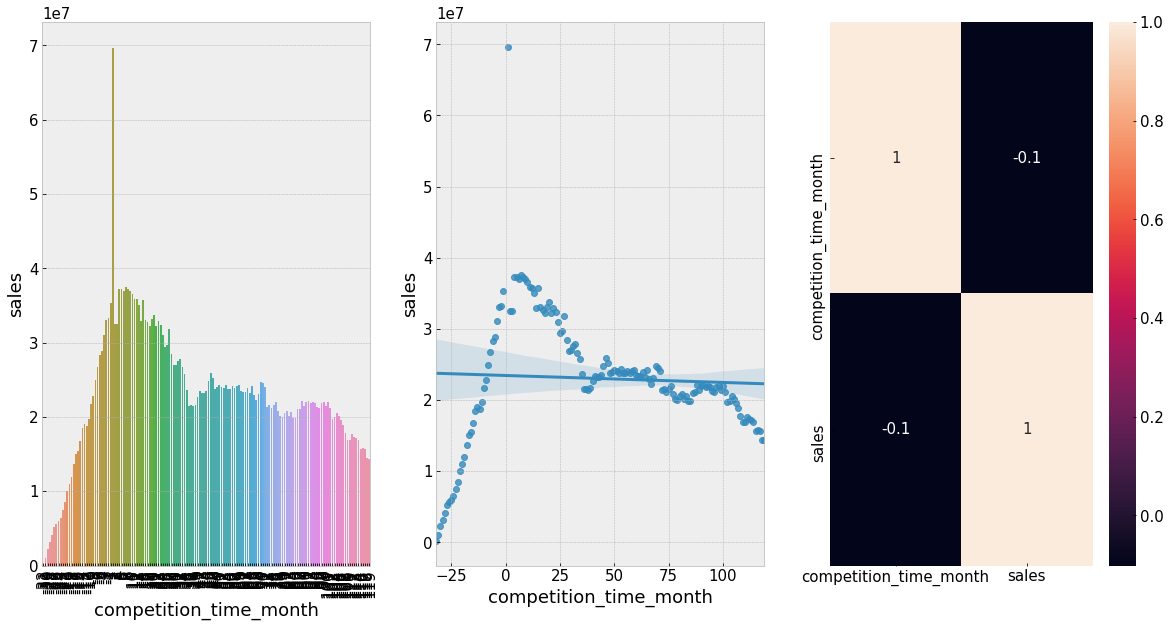

In [39]:
# H3, Lojas com competidores a mais tempo tendem a vender mais
# **FALSO** LOJAS COM COMPETIDORES A MENOS TEMPO VENDEM MAIS

plt.rcParams['figure.figsize'] = [20, 10]


plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120 ) & (aux1['competition_time_month'] !=0 )]
sns.barplot(x='competition_time_month', y = 'sales', data = aux2);
plt.xticks( rotation= 90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y = 'sales', data = aux2);


plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True)
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);



In [40]:
# H4  LOJAS COM PROMOÇOES ATIVAS POR MAIS TEMPO VENDEM MAIS
# # Falso



# # plt.subplot(2,3,1)
# # aux2 = aux1[aux1['promo_time_week']>0]
# # sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);

# # plt.subplot(2,3,2)
# # aux2 = aux1[aux1['promo_time_week']>0]
# # sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);


# plt.subplot(2,3,3)
# aux2 = aux1[aux1['promo_time_week']>0]
# sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);

# # plt.subplot(2,3,4)
# # aux3 = aux1[aux1['promo_time_week']<0]
# # sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

# plt.subplot(2,3,5)
# sns.heatmap( aux1.corr(method = 'pearson'), annot = True);




In [41]:
# H5 LOJAS COM MAIS DIAS DE PROMOÇÃO DEVERIA VENDER MAIS
#  PRÓXIMO CICLO DO CRISP




In [42]:
# H6 LOJAS COM MAIS PROMOÇÕES CONSECUTIVAS DEVERIAM VENDER MAIS
# FALSO

df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()






,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


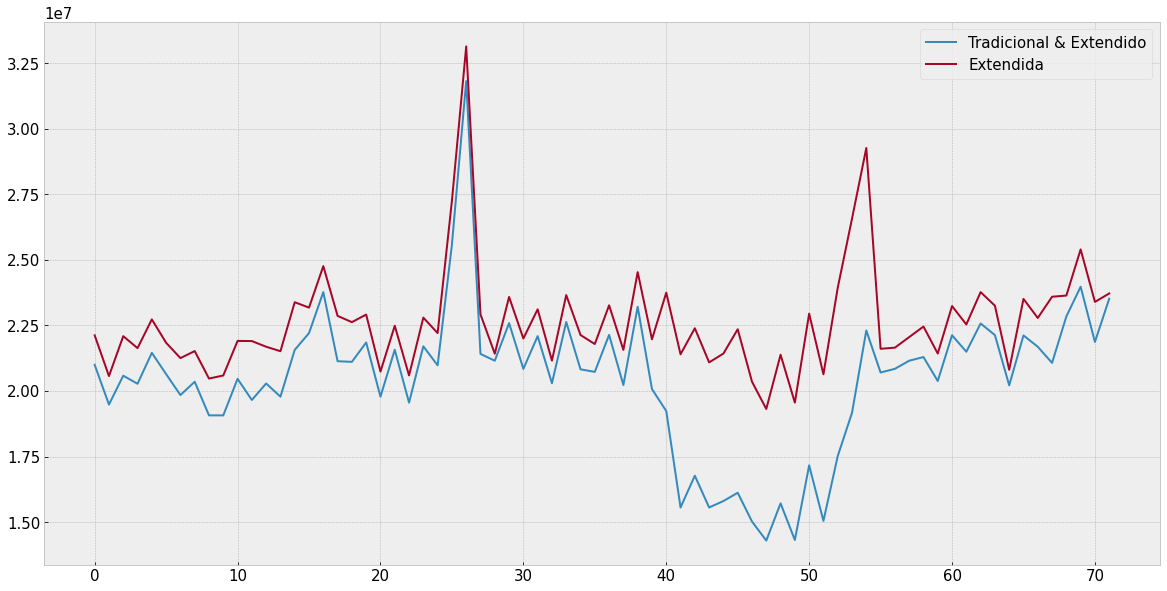

In [43]:

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional & Extendido', 'Extendida'])



<AxesSubplot:xlabel='year', ylabel='sales'>

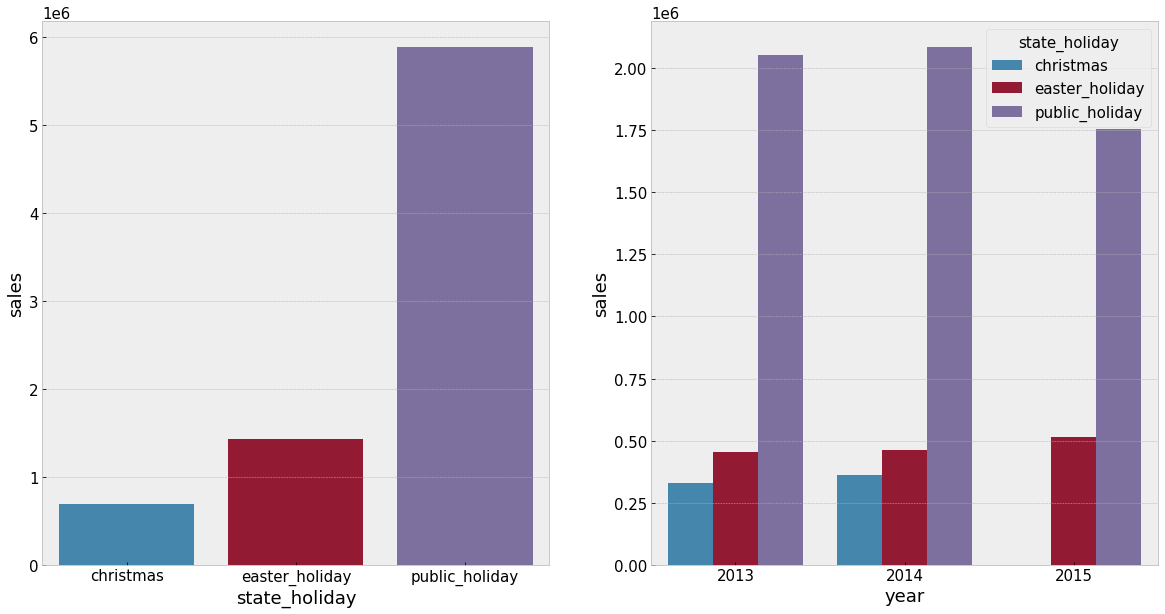

In [44]:
# H7 LOJAS ABERTAS DURANTE O FERIADO DE NATAL DEVERIAM VENDER MAIS
# falso
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day'] 
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y = 'sales',hue= 'state_holiday', data = aux2)


In [45]:
# H8 LOJAS DEVERIAM VENDER MAIS AO LONGO DOS ANOS


In [46]:
# H9 LOJAS DEVERIAM VENDER MAIS NO SEGUNDO SEMESTRE

## 4.3Análise Multivariada

### 4.3.1 Numerical Attributes

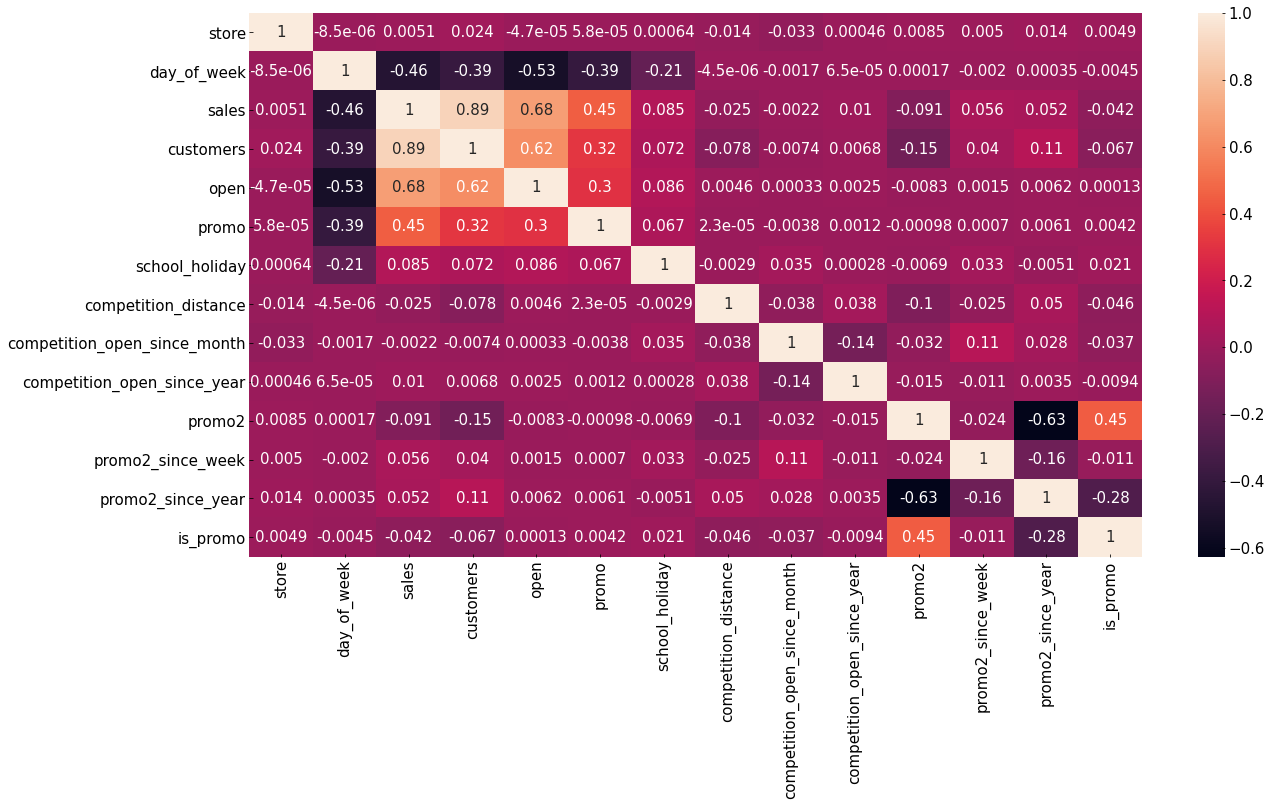

In [47]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2 Categorical Attributes

In [48]:
b = df4.drop(['month_map', 'promo_interval'] , axis=1, inplace = False)
a = b.select_dtypes( include = 'object')


In [49]:
def cramer_v (x,y):
    
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr =max(0, chi2 - ((k-1)* (r-1))/ (n-1))
    
    kcorr =  k - (k-1)**2/(n-1)
    rcorr =  r - (r-1)**2/(n-1)
    
    
    return np.sqrt((chi2corr/n)/ (min(kcorr-1, rcorr-1)))

In [50]:
# APLICANDO O METODO DE CRAMER V
# PARA O V DE CRAMER A CORRELAÇÃO É APENAS POSITIVA E ELA VAI DE 0 A 1
#  SENDO QUE MAIS PERTO DO ZERO A CORRELAÇÃO MENOR A CORRELAÇÃO E QUANTO MAIS PERTO DE 1 MAIOR A CORRELAÇÃO

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])



d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

# TODO CRAMER V UTILIZADO PODE APRESENTAR ERRO NO SEU CALCULO, POR ISSO É IMPORTANTE QUE SE CALCULE
# O CRAMER_V BIAS, ESSA CORREÇÃO JA FOI FEITA NA FUNÇÃO ACIMA



<AxesSubplot:>

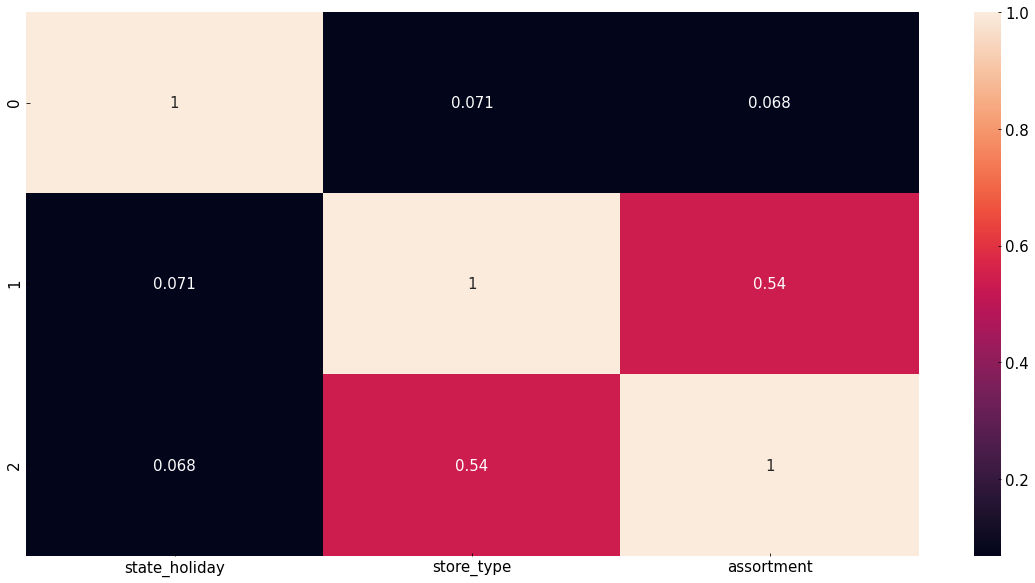

In [51]:
sns.heatmap( d, annot= True)

# 5.0 Preparação dos dados

In [52]:
# OS DADOS QUE VAO ENTRAR NO NOSSO MODELO DE MACHINE LEARNING DEVEM SER NUMÉRICOS E NORMALIZADOS


In [53]:
df5 = df4.copy()

## 5.1 Normalização


## 5.2 Rescaling


### 5.2.1 Min-Max Scaler


In [54]:
# Mantem o formato das curvas e distribuições, porem ele aumenta o **range das variaveis**
# Ruim para dados OUTLIERS

# ROBUST SCALLER PARA CURVAS COM OUTLIERS



In [55]:
a = df5.select_dtypes( include = ['int64', 'float64'])

In [59]:
# variaveis utilizadas no Rescaling
# year
# competition distance
# competition time month
# promo time week

rs = RobustScaler()
mms = MinMaxScaler()

# Competition Distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/competition_distance_scaler.pkl','wb'))

# Competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/competition_time_month_scaler.pkl','wb'))

# Promo time month
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/year_scaler.pkl','wb'))





D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


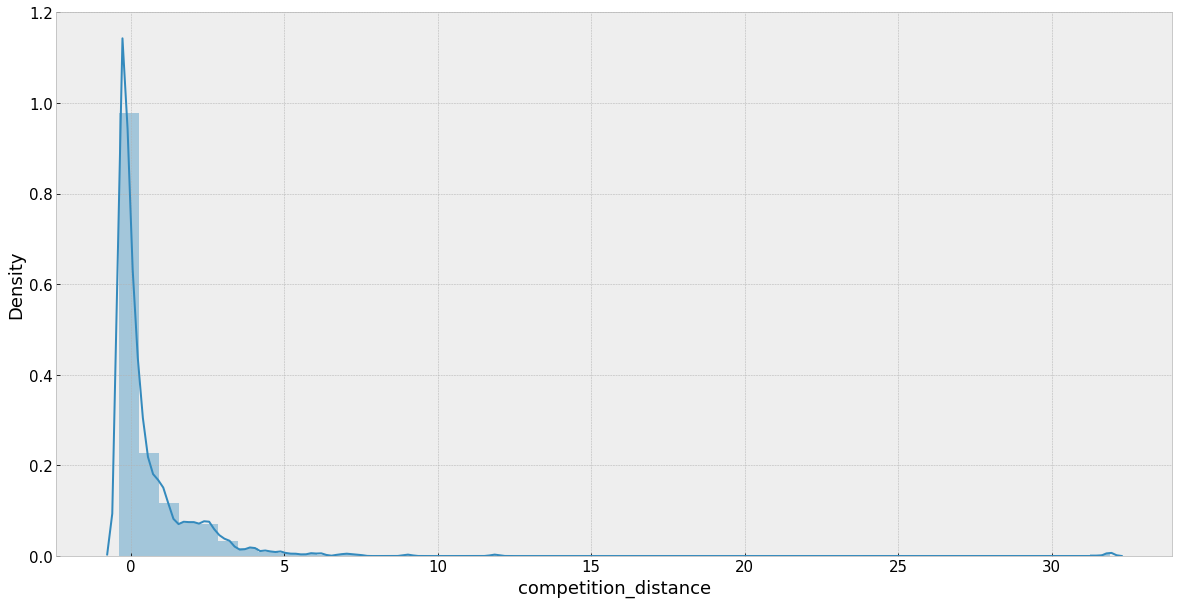

In [61]:
sns.distplot(df5['competition_distance']);

D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


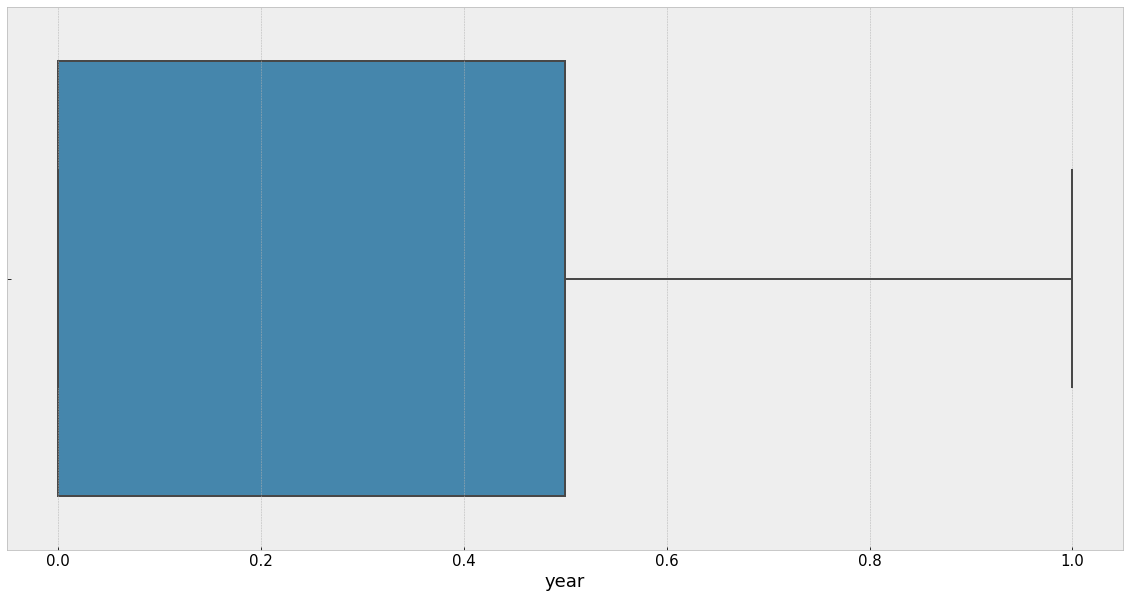

In [62]:
sns.boxplot(df5['year']);

## 5.3 Transformation


### 5.3.1 Encoding

In [63]:
# State Holiday - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns= ['state_holiday'])

# Store type - LABEL ENCONDING
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/store_type_scaler.pkl','wb'))


# assortment - ORDINAL ENCODING
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

In [64]:
df5['sales'] = np.log1p( df5['sales'])

D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

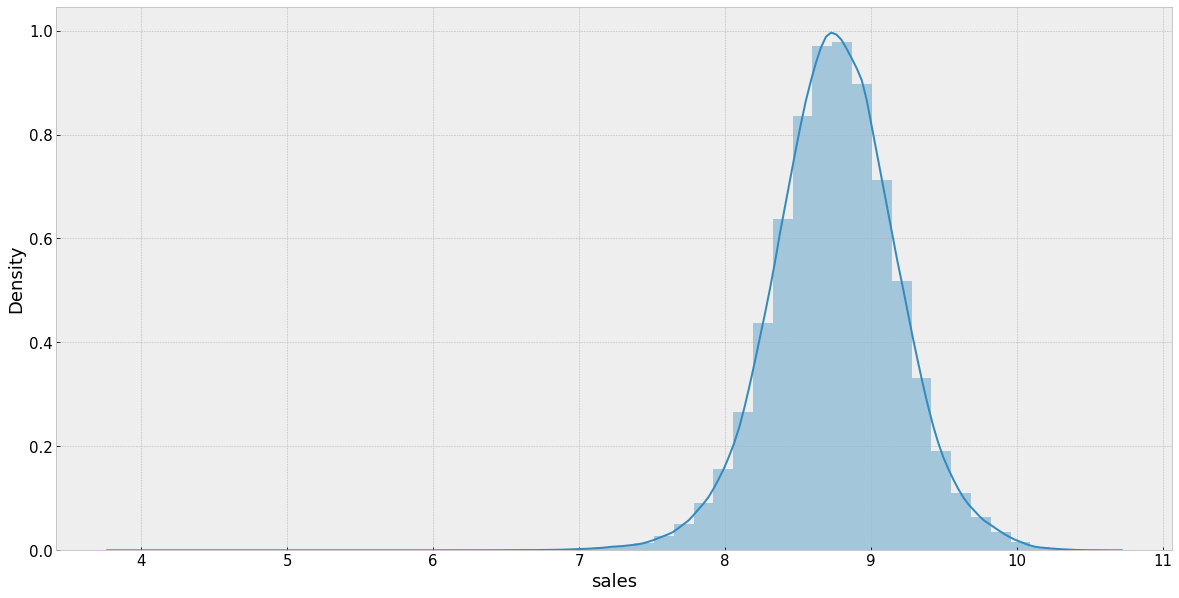

In [65]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [66]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2*np.pi/7)))


In [67]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2*np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2*np.pi/12)))



In [68]:
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2*np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2*np.pi/30)))


In [69]:
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2*np.pi/52)))



In [70]:
df5.head(10)

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,555,1,1,1,2,1,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,625,1,1,1,0,1,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,821,1,1,1,0,1,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1498,1,1,1,2,3,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,559,1,1,1,0,1,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
5,6,5,2015-07-31,8.639765,589,1,1,1,0,1,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
6,7,5,2015-07-31,9.638545,1414,1,1,1,0,3,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
7,8,5,2015-07-31,9.046998,833,1,1,1,0,1,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
8,9,5,2015-07-31,9.055556,687,1,1,1,0,3,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
9,10,5,2015-07-31,8.879890,681,1,1,1,0,1,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selection

In [71]:
df6 = df5.copy()

## 6.1 Seleção Univariada ( Filter Methods)

In [72]:
# CLASSIFICA AS VARIAVEIS COMO RELEVANTES E NAO RELEVANTES PARA O MODELO
# RELEVANCIA

## 6.2 Seleção por importância (Embedded method)

## 6.3 Seleção por SubSet( Wrapper Methods)

In [73]:
# BORUTA é um algoritimo que pode realizar a separação do subset para nós
# com o boruta pode-se calcular o p-valor (utilizado para determinar se uma 
# hipotese é verdadeira ou falsa por exemplo)

## 6.4 - Split DF into training and testing

In [74]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [75]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [76]:
#  Training dataset
X_train = df6[df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# Testing dataset
X_test = df6[df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print( 'training min date: {}'.format(X_train['date'].min()))
print( 'training max date: {}'.format(X_train['date'].max()))

print( '\nTesting min date: {}'.format(X_test['date'].min()))
print( 'Testing max date: {}'.format(X_test['date'].max()))


training min date: 2013-01-01 00:00:00
training max date: 2015-06-18 00:00:00

Testing min date: 2015-06-19 00:00:00
Testing max date: 2015-07-31 00:00:00


## 6.5 - boruta as feature selection

In [77]:
pd.set_option('display.max_columns', None)

In [78]:
# defining variables
X_train_n = X_train.drop(['date','sales','month_map','promo_interval'], axis=1).values
y_train_n = y_train.values.ravel()

# Define random forest
rf = RandomForestRegressor( n_jobs=-1)



In [79]:
# #Define Boruta
# boruta = BorutaPy ( rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)


## 6.5.1 - Best Features from Boruta

In [80]:
# cols_selected = boruta.support_.tolist()

# X_train_fs = X_train.drop(['date','sales','month_map','promo_interval'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Not Selected Boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [81]:
# cols_not_selected_boruta

## 6.6 - Manual Feature Selection

In [82]:
cols_selected_boruta = ['store', 'customers', 'promo', 'store_type', 'assortment', 'competition_distance',
 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
 'month_cos', 'month_sin', 'week_of_year_sin', 'day_sin','day_cos', 'week_of_year_cos']

cols_selected_boruta_full = ['store', 'customers', 'promo', 'store_type', 'assortment', 'competition_distance',
 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
 'month_cos', 'month_sin', 'week_of_year_sin', 'day_sin','day_cos', 'week_of_year_cos','date','sales']


cols_not_selected_boruta = ['day_sin', 'is_promo', 'month_sin', 'open', 'school_holiday',
 'state_holiday_christmas', 'state_holiday_easter_holiday', 'state_holiday_public_holiday',
 'state_holiday_regular_day', 'week_of_year_sin', 'year']


# # Features to add
# feat_to_add = ['date','sales']

# # final Features
# # cols_selected_boruta.extend( feat_to_add)

# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend(feat_to_add)


# 7.0 - Machine Learning Modeling


In [83]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 - Average model


In [84]:
x_training = X_train[cols_selected_boruta_full]

In [85]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))
    

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error( y, yhat)) 
    
    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])


In [86]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
# Prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns={'sales':'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# # Performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [87]:
from sklearn.linear_model import LinearRegression, Lasso

In [88]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1344.347775,0.183431,3371.671836


## 7.2.1 - Linear Regression Model - Cross Validation

In [89]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', LinearRegression)
lr_result_cv



KFold Number:5
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1344.347775  0.183431  3371.671836


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1858.07+/-0.0,0.2+/-0.0,4630.76+/-0.0


## 7.3 Linear Regression Regularized Model - Lasso

In [90]:
# Model
lrr = Lasso( alpha=0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1( y_test ), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1413.378578,0.187075,3410.485128


## 7.3.1 - Lasso - Cross Validation

In [91]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', Lasso)
lrr_result_cv


KFold Number:5
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1344.347775  0.183431  3371.671836


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2203.14+/-0.0,0.24+/-0.0,4879.12+/-0.0


## 7.4 Random Forest Regressor

In [92]:
from sklearn.ensemble import RandomForestRegressor

In [93]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,377.377423,0.052974,582.243654


## 7.4.2 Random Forest Regressor - Cross Validation

In [94]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', RandomForestRegressor)
rf_result_cv


KFold Number:5
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1344.347775  0.183431  3371.671836


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,582.55+/-0.0,0.07+/-0.0,831.35+/-0.0


## 7.5 XGBoost

In [95]:
import xgboost as xgb

In [96]:
# Model
model_xgb =xgb.XGBRegressor( objective='reg:squarederror',n_estimators=100, eta = 0.01, max_depth=10,
                            subsample=0.7,colsample_bytree=0.9).fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb))
xgb_result

D:\anaconda\envs\Curso_data_science\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6684.378991,0.951597,7318.818509


## 7.5.2 XGBoost - Cross Validation

In [97]:
xgb_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor',xgb.XGBRegressor)
xgb_result_cv


KFold Number:5
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1344.347775  0.183431  3371.671836


D:\anaconda\envs\Curso_data_science\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,521.19+/-0.0,0.06+/-0.0,721.73+/-0.0


## 7.6 Compare Models Performance

In [98]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,377.377423,0.052974,582.243654
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1344.347775,0.183431,3371.671836
0,Linear Regression - Lasso,1413.378578,0.187075,3410.485128
0,XGBoost Regressor,6684.378991,0.951597,7318.818509


In [99]:
# Cross Validation para Time Series
x_training = X_train[cols_selected_boruta_full]

In [100]:
# def cross_validation( x_training, kfold, model_name, model):

#     mae_list = []
#     mape_list = []
#     rmse_list = []


#     for k in reversed(range(1,kfold+1)):
#         print('\nKFold Number:{}'.format(k))

#         # start and end of validation time
#         validation_start_date = x_training['date'].max() - datetime.timedelta( days= k*6*7)
#         validation_end_date = x_training['date'].max() - datetime.timedelta( days= (k-1)*6*7)

#         # filtering dataset
#         training = x_training[x_training['date']< validation_start_date]
#         validation = x_training[(x_training['date']>=validation_start_date) & 
#                                 (x_training['date']<=validation_end_date)]
#         # training and validation dataset
#         ytraining = training['sales']
#         yvalidation = validation['sales']
#         xtraining = training.drop(['date','sales'], axis=1)
#         xvalidation = validation.drop(['date','sales'], axis=1)

#         # Model
#         m = model().fit(xtraining, ytraining)


#         # Prediction
#         yhat = m.predict(xvalidation)


#         # Performance
#         m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))
#         print(lr_result)

#         mae_list.append( m_result['MAE'])
#         mape_list.append(m_result['MAPE'])
#         rsme_list.append(m_result['RMSE'])


#         return pd.DataFrame({'Model Name': model_name,
#                              'MAE CV': np.round( np.mean(mae_list),2).astype( str ) + '+/-' + np.round( np.std(mae_list),2).astype( str ),
#                              'MAPE CV': np.round( np.mean(mape_list),2).astype( str ) + '+/-' + np.round( np.std(mape_list),2).astype( str ),
#                              'RMSE CV': np.round( np.mean(rmse_list),2).astype( str ) + '+/-' + np.round( np.std(rmse_list),2).astype
#          ( str )}, index=[0])



## 8.0 - Hyperparameter fine tunning

In [101]:
# Os hiperparametros são os parametros que3 regem os modelos de machine learning

## 8.1 - Random Search fine tunning

In [102]:
import random
param_tunned = {
        'n_estimators':3000,
        'eta':0.03,
        'max_depth':5,
        'subsample':0.7,
        'colssample_bytree':0.7 ,
        'min_child_weight':3
}



In [103]:

# Model
model_xgb_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=param_tunned['n_estimators'],
                            eta = param_tunned['eta'],
                            max_depth=param_tunned['max_depth'],
                            subsample=param_tunned['subsample'],
                            colsample_bytree=param_tunned['colssample_bytree'],
                            min_child_weight= param_tunned['min_child_weight']).fit( x_train, y_train)

# Prediction
yhat_xgb_tunned = model_xgb_tunned.predict( x_test)


# Performance
xgb_result = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tunned))
xgb_result

D:\anaconda\envs\Curso_data_science\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,354.347309,0.051206,538.753831


# 9.0 - Tradução e interpretação do erro


In [104]:
df9 = X_test[cols_selected_boruta_full]
df9['sales'] = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(yhat_xgb_tunned)

<ipython-input-104-cd408fc9a18e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
<ipython-input-104-cd408fc9a18e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['prediction'] = np.expm1(yhat_xgb_tunned)


In [108]:
df9['error'] = df9['prediction'] - df9['sales']
df9['error_rate'] = df9['prediction'] / df9['sales']

<ipython-input-108-8d237a5a5eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['prediction'] - df9['sales']
<ipython-input-108-8d237a5a5eef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['prediction'] / df9['sales']


## 9.1 - Business Performance

In [109]:
# Sum of Predictions
df91 = df9[['store', 'prediction']].groupby('store').sum().reset_index()
df91


,store,prediction
0,1,166943.484375
1,2,189886.140625
2,3,247466.703125
3,4,358327.593750
4,5,169541.953125
...,...,...
1110,1111,167599.906250
1111,1112,309780.406250
1112,1113,237143.500000
1113,1114,817066.750000


In [112]:
# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario'] = df92['prediction'] + df92['MAE']

df92





,store,prediction,MAE,MAPE,worst_scenario,best_scenario
0,1,166943.484375,196.582170,0.045805,166746.902205,167140.066545
1,2,189886.140625,404.771801,0.079521,189481.368824,190290.912426
2,3,247466.703125,334.386824,0.050593,247132.316301,247801.089949
3,4,358327.593750,402.898094,0.040045,357924.695656,358730.491844
4,5,169541.953125,221.933096,0.049226,169320.020029,169763.886221
...,...,...,...,...,...,...
1110,1111,167599.906250,358.853793,0.066507,167241.052457,167958.760043
1111,1112,309780.406250,445.643832,0.048486,309334.762418,310226.050082
1112,1113,237143.500000,285.784457,0.042439,236857.715543,237429.284457
1113,1114,817066.750000,1241.845756,0.053176,815824.904244,818308.595756


In [113]:
df92.sort_values('MAPE', ascending=False)

,store,prediction,MAE,MAPE,worst_scenario,best_scenario
908,909,275977.812500,4106.451830,0.220117,271871.360670,280084.264330
875,876,210628.421875,2444.398130,0.166014,208184.023745,213072.820005
721,722,323633.843750,1198.320194,0.164015,322435.523556,324832.163944
291,292,103845.609375,2057.715666,0.152089,101787.893709,105903.325041
303,304,281881.781250,950.524929,0.147756,280931.256321,282832.306179
...,...,...,...,...,...,...
852,853,356732.281250,266.068491,0.027688,356466.212759,356998.349741
202,203,255642.218750,195.373614,0.027566,255446.845136,255837.592364
1042,1043,300372.156250,221.805149,0.026626,300150.351101,300593.961399
958,959,260809.296875,194.994688,0.026556,260614.302187,261004.291563


<AxesSubplot:xlabel='store', ylabel='MAPE'>

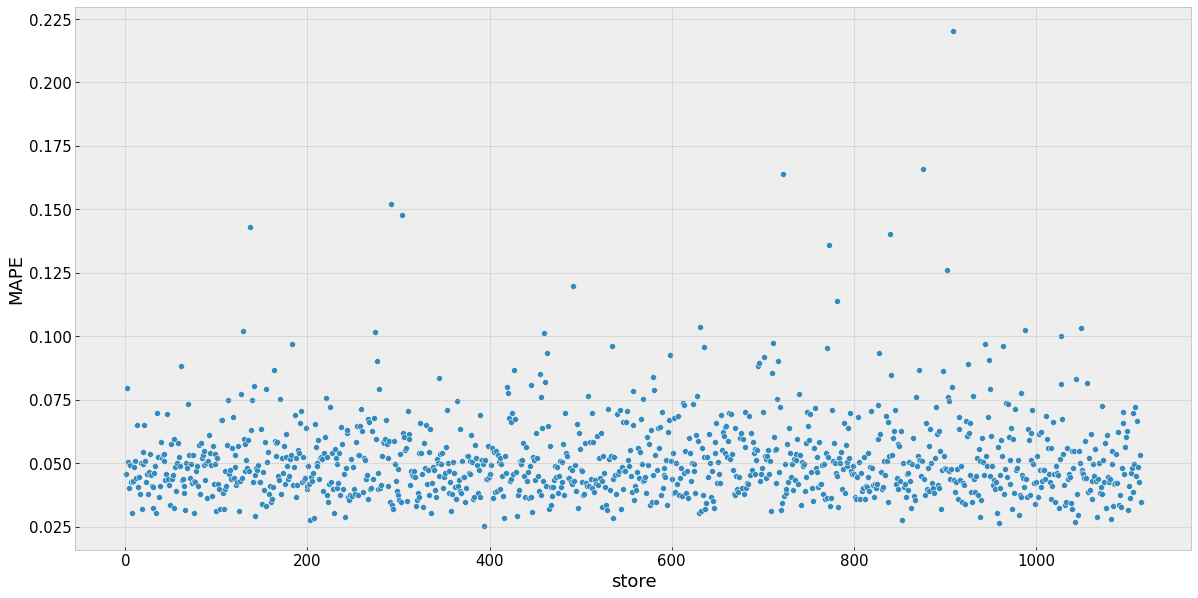

In [114]:
sns.scatterplot(x='store',y='MAPE', data=df92)

## 9.2 - Total Performance

In [115]:
df93 = df92[['prediction','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,prediction,"R$287,065,376.00"
1,worst_scenario,"R$286,667,890.07"
2,best_scenario,"R$287,462,839.21"


## 9.3 - Machine Learning Performance

In [116]:
df9['error'] = df9['prediction'] - df9['sales']
df9['error_rate'] = df9['prediction'] / df9['sales']


<ipython-input-116-8d237a5a5eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['prediction'] - df9['sales']
<ipython-input-116-8d237a5a5eef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['prediction'] / df9['sales']


D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\Curso_data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction', ylabel='error'>

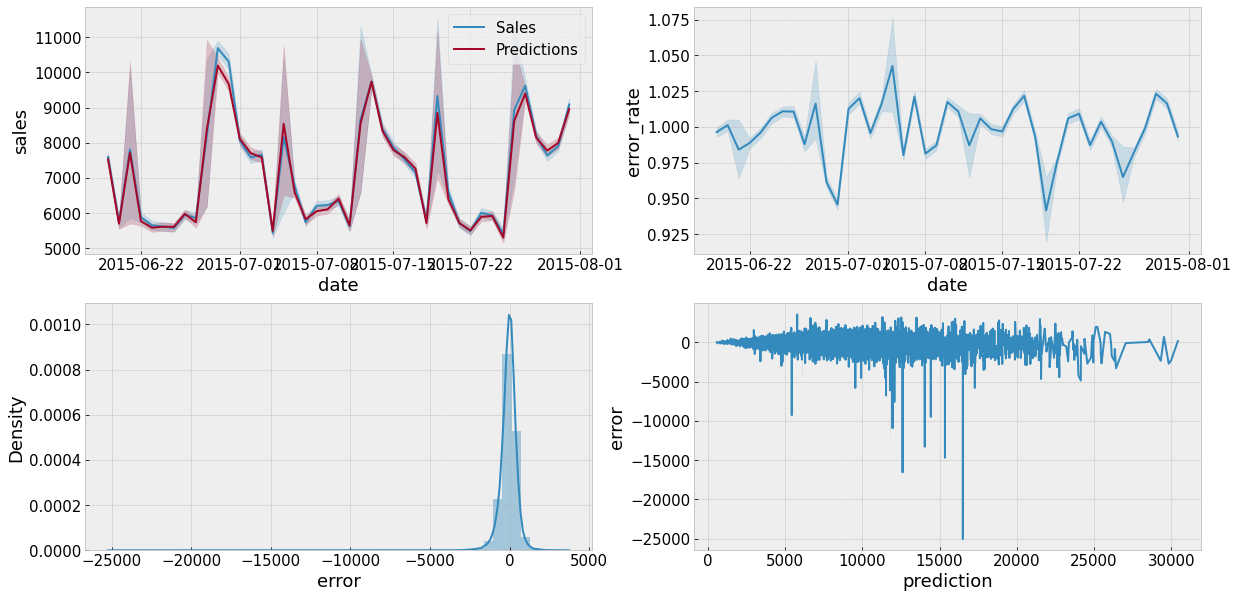

In [117]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales');
sns.lineplot(x='date', y='prediction', data=df9, label='Predictions');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);

plt.subplot(2,2,3)
sns.distplot(df9['error']);


plt.subplot(2,2,4)
sns.lineplot(df9['prediction'], df9['error']);




# 10.0 - Deploy Model to Production

In [118]:
import pickle
pickle.dump( model_xgb_tunned, open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/model_xgb.pkl','wb'))

## 10.1 - Rossman Class

In [119]:
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load( open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/competition_distance_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load( open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/promo_time_week_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load( open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/competition_time_month_scaler.pkl','rb'))
        self.year_scaler                   = pickle.load( open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/year_scaler.pkl','rb'))
        self.store_type_scaler             = pickle.load( open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/store_type_scaler.pkl','rb'))

        
        
    def data_cleaning(self,df1):
        
        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x:inflection.underscore(x)
        cols_new = list( map(snakecase, cols_old))

        #rename
        df1.columns = cols_new
        ## 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA
        #competition_distance              
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan ( x ) else x )

        #competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week               
        df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

        #promo2_since_year               
        df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

        #promo_interval                  
        month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6: 'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)


        ## 1.6 Data Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

        return df1

    def feature_engineering(self, df2):

        #year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply (lambda x: x.days ).astype(np.int64)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str ) 
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x == 'c' else 'regular_day')

        ## 3.1 Filtragem das Linhas
        df2 = df2[(df2['open'] != 0 ) & (df2['sales'] > 0)]

        ## 3.2 Seleção das colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1)
        
        return df2
        
def data_preparation(self,df5):

    ## 5.2 Rescaling
    # Competition Distance
    df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

    # Competition time month
    df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
    
    # Promo time month
    df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
    
    # year
    df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
    
    ### 5.3.1 Encoding
    # State Holiday - One Hot Encoding 
    df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns= ['state_holiday'])

    # Store type - LABEL ENCONDING
    df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

    # assortment - ORDINAL ENCODING
    assortment_dict = {'basic':1, 'extra':2, 'extended':3}
    df5['assortment'] = df5['assortment'].map(assortment_dict)

    ### 5.3.3 Nature Transformation
    # day of week
    df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2*np.pi/7)))
    df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2*np.pi/7)))

    # month
    df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2*np.pi/12)))
    df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2*np.pi/12)))

    # day
    df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2*np.pi/30)))
    df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2*np.pi/30)))

    # week of year
    df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2*np.pi/52)))
    df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2*np.pi/52)))

    cols_selected = ['store', 'customers', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
         'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin', 'week_of_year_sin', 'day_sin',
         'day_cos', 'week_of_year_cos']
    
    return df5[cols_selected]



## 10.2 - API Handler

In [127]:
import pickle
import pandas as pd


from   flask              import Flask, request, Response
from   Rossmann_sales_predictions import Rossmann

# Loading Model
model = pickle.load( open('C:/Users/Pedro Enrique/Desktop/Projetos/ciencia de dados/Rossman_sales_predictions/model_xgb.pkl', 'rb'))


# Initialize API
app = Flask( __name__ )



@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # Quando temos dados
        if isinstance (test_json, dict): # Unique example
            test_raw = pd.DataFrame( test_json, index=[0])
        else: # Multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
    
#     Instantiate Rossmann Class
        pipeline = Rossmann()
    
#         data cleaning
        df1 = pipeline.data_cleaning(test_raw)
#         feature engineering
        df2 = pipeline.feature_engineering(df1)
#         data preparation
        df3 = pipeline.data_preparation(df2)
#         prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
    
        return df_response
    else: # Quando não temos dados
        return Response('{}',status=200, mimetype='application/json' )
    

if __name__ == '__main__':
    app.run( '0.0.0.0' )


ModuleNotFoundError: No module named 'Rossmann_sales_predictions'

## 10.3 - API Tester